In [1]:
!apt-get update
!apt install -y chromium-chromedriver
%pip install requests beautifulsoup4 selenium textblob vaderSentiment matplotlib seaborn nltk
%pip install transformers
%pip install datasets
%pip install -q google-colab-selenium

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,904 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,521 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu jammy-

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import regex as re
import string
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
import torch
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium import webdriver

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# SENTIMENT ANALYSIS:

## DATA EXTRACTION: Retrieving comments from webtoon *Lore Olympus* ! 🌐

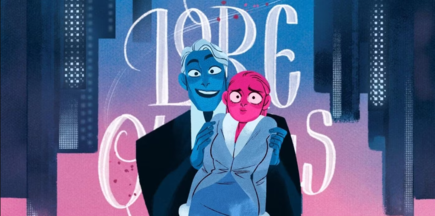

For this project we will work with the comments section on the 1st chapter of Lore Olympus that we can find on the official website 'Webtoon.com'.

*Lore Olympus is actually the first Webtoon that made me buy fast pass on the app*

### Setting the driver & loading the comments :



In [3]:
driver = gs.Chrome()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
def retrieve_comments_from_webtoon(np, url):
  """
  np: integer : number of pages to look at in order to retrieve comments from these pages.
  url : url used for your webtoon
  """
  comments_data = []
  comments_info = str()

  try:
      for i in range(1, np + 1):
          # Regex to change the episode number in rhe url
          episode_url = re.sub(r"(episode-)(\d+)|(episode_no=)(\d+)", lambda match: f"{match.group(1) or match.group(3)}{i}", url)
          print(f"Access to EP no.{i} : {episode_url}")

          # Website access
          driver.get(episode_url)
          time.sleep(1)

          # Click on "More" button to access as much comments as possible
          while True:
              try:
                  load_more_button = driver.find_element(By.CLASS_NAME,"wcc_CommentMore__more")
                  load_more_button.click()
                  print("Loading more comments !")
                  time.sleep(1)  # Attendre le chargement des nouveaux commentaires
              except Exception:
                  print("No 'More' button left or error !")
                  break

          # Retrieve comments
          try:
            comment_elements = driver.find_elements(By.CLASS_NAME, "wcc_CommentList__list")
            if len(comment_elements)>0:
              comments_info = comments_info + comment_elements[0].text
              print("Comment(s) loaded.")
            else:
              print("There's no comment(s) to load !")
          except Exception as e:
              print(f"An error occure during the comments extraction for episode no.{i}: {e}")

  finally:
      driver.quit()

  return comments_info

In [5]:
url = "https://www.webtoons.com/en/romance/lore-olympus/episode-1/viewer?title_no=1320&episode_no=1"
comments = retrieve_comments_from_webtoon(1,url)

Access to EP no.1 : https://www.webtoons.com/en/romance/lore-olympus/episode-1/viewer?title_no=1320&episode_no=1
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !
Loading more comments !

### Data cleaning:

In [6]:
# Removing what we don't need
data = comments.replace('\nTOP','')
data=data.replace('\n',' ')
data=data.replace("\'","")
data

'셀 Mar 04, 2018 EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS SM HOPE YOU NEWCOMERS ENJOY!! Replies 98 57547 905 Maddie1137 Mar 04, 2018 The art style is mesmerizing! Cant wait to see where this goes, this myth has always fascinated me~ [+please like the chapters to support the author/boost it in the charts!] Replies 27 54364 677 Amalia Herrera Mar 04, 2018 Im from discover too.EDIT: I cant believe I got top comment this has never happened to me. So I guess id just like to say thank you for liking my comment. I love this myth and I cant wait to see the authors interpretation of this story come about😀💖🖤 Replies 17 30962 1265 justatinywifrog Mar 04, 2018 HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MORE THAN ZEUS LIKES TO FUCK EVERYTHING THAT MOVES KTHNXSBAI Replies 33 1830 24 Mikan200 Mar 04, 2018 Hades phone: Apple=Pomegranate lol Replies 9 949 6 Anna Rukat Jul 01, 2018 this satisfies my inner mythology nerd in a strange way. here, have some trivia: Minthe was a naiad, a kind of nymph, 

In [7]:
# Catching informations we want
pattern = re.compile(r'(\w{3} \d{2}, \d{4}) (.*?) (Replies \d+|Reply\s?) (\d+) (\d+) ', re.DOTALL)
matches = pattern.findall(data)

In [8]:
formated_list= list()
comments_only= list()
for match in matches:
    date, comment, replies, like, dislike = match
    formated_list.append({
        'Date': date,
        'Comment': comment.strip(),
        'Likes': int(like),
        'Dislikes': int(dislike)
    })
    comments_only.append({
        'Comment': comment.strip()
    })

In [9]:
#Saving data into csv files
df=pd.DataFrame(formated_list)
comments_only_df=pd.DataFrame(comments_only)
df.to_csv('Lore_Olympus_comments.csv', index=False,encoding="utf-8-sig")
#comments_only_df.to_csv('Lore_Olympus_comments_only.csv', index=False,encoding="utf-8-sig")

In [10]:
df.head()

,Date,Comment,Likes,Dislikes
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677
2,"Mar 04, 2018",Im from discover too.EDIT: I cant believe I go...,30962,1265
3,"Mar 04, 2018",HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MO...,1830,24
4,"Mar 04, 2018",Hades phone: Apple=Pomegranate lol,949,6


## QUICK EDA  📊:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556 entries, 0 to 6555
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      6556 non-null   object
 1   Comment   6556 non-null   object
 2   Likes     6556 non-null   int64 
 3   Dislikes  6556 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 205.0+ KB


**Like and Dislike distribution:**

,Likes,Dislikes
count,6556.000000,6556.000000
mean,24.578401,1.168243
std,1050.037753,21.416196
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,57547.000000,1265.000000


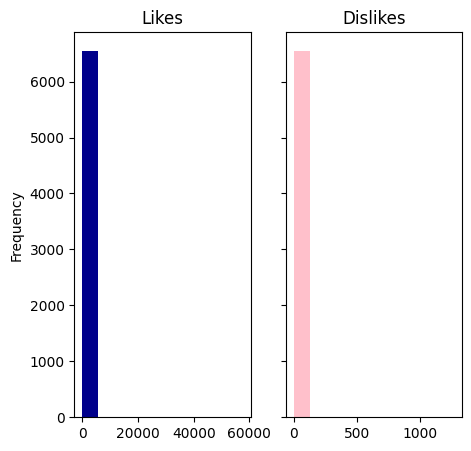

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(5,5), sharey=True)

df["Likes"].plot(kind='hist',color='darkblue', ax=axes[0])
axes[0].set_title("Likes")

df["Dislikes"].plot(kind='hist',color='pink', ax=axes[1])
axes[1].set_title("Dislikes")

df[['Likes','Dislikes']].describe()

**Lenght and word count of comments distributions:**

,Comment
count,6556.000000
mean,76.176327
std,69.155556
min,1.000000
25%,32.000000
50%,58.000000
75%,96.000000
max,505.000000


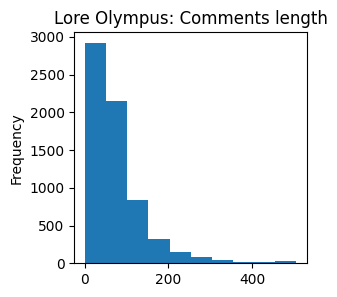

In [13]:
df['Comment'].str.len().plot(kind='hist', title='Lore Olympus: Comments length', figsize=(3,3))
df['Comment'].str.len().describe()

,Comment
count,6556.000000
mean,14.600671
std,13.158452
min,1.000000
25%,6.000000
50%,11.000000
75%,18.000000
max,101.000000


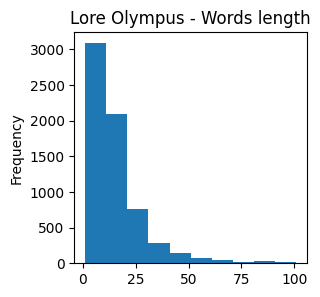

In [14]:
df['Comment'].str.split().apply(len).plot(kind='hist', title='Lore Olympus - Words length', figsize=(3,3))
df['Comment'].str.split().apply(len).describe()

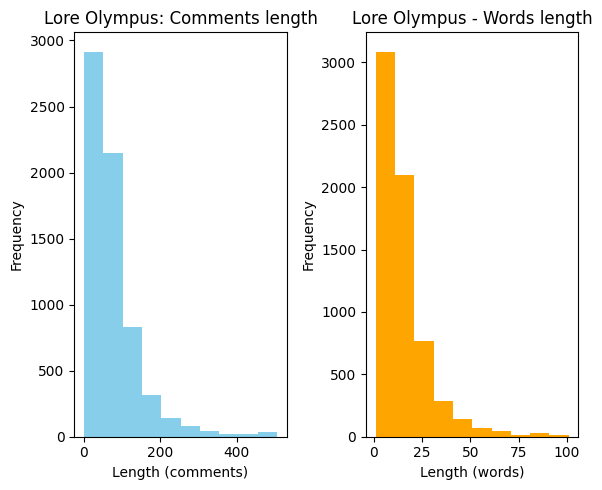

Statistics for Lore Olympus: Comments length:
 count    6556.000000
mean       76.176327
std        69.155556
min         1.000000
25%        32.000000
50%        58.000000
75%        96.000000
max       505.000000
Name: Comment, dtype: float64

Statistics for Lore Olympus - Words length:
 count    6556.000000
mean       14.600671
std        13.158452
min         1.000000
25%         6.000000
50%        11.000000
75%        18.000000
max       101.000000
Name: Comment, dtype: float64


In [15]:
import matplotlib.pyplot as plt

# Créer une figure avec deux sous-plots alignés horizontalement
fig, axes = plt.subplots(1, 2, figsize=(6,5))

# Histogramme des longueurs de commentaires
df['Comment'].str.len().plot(
    kind='hist',
    title='Lore Olympus: Comments length',
    color='skyblue',
    ax=axes[0]
)
axes[0].set_xlabel('Length (comments)')
axes[0].set_ylabel('Frequency')

# Histogramme des longueurs en mots
df['Comment'].str.split().apply(len).plot(
    kind='hist',
    title='Lore Olympus - Words length',
    color='orange',
    ax=axes[1]
)
axes[1].set_xlabel('Length (words)')
axes[1].set_ylabel('Frequency')

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

# Affichage des statistiques descriptives
comment_length_stats = df['Comment'].str.len().describe()
word_length_stats = df['Comment'].str.split().apply(len).describe()

print("Statistics for Lore Olympus: Comments length:\n", comment_length_stats)
print("\nStatistics for Lore Olympus - Words length:\n", word_length_stats)

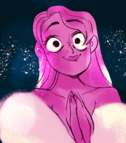

Now we got something cleaner to work with !

## DATA PRE-PROCESSING ⚙️ : Preparing our data for sentiment analysis

In [16]:
df.head(3)

,Date,Comment,Likes,Dislikes
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677
2,"Mar 04, 2018",Im from discover too.EDIT: I cant believe I go...,30962,1265


In [17]:
def remove_punctuation(text):
  """
   Remove punctuation from text
  """
  translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  cleaned_text = text.translate(translation_table)
  punctuationfree = ' '.join(cleaned_text.split())
  return punctuationfree

def remove_emojis(text):
  """
  Regular expression to match emojis
  """
  emoji_pattern = re.compile(
      "["
      "\U0001F600-\U0001F64F"  # Emoticons
      "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
      "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
      "\U0001F700-\U0001F77F"  # Alchemical Symbols
      "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
      "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
      "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
      "\U0001FA00-\U0001FAFF"  # Chess Symbols
      "\U00002702-\U000027B0"  # Miscellaneous Symbols
      "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
      "]+",
      flags=re.UNICODE
  )
  return emoji_pattern.sub(r'', text)

In [18]:
def data_processing_pipeline(df):
  # remove punctuation & emojis
  df['Clean_comment'] = df['Comment'].apply(lambda x:remove_emojis(remove_punctuation(x)))

data_processing_pipeline(df)
df.head(3)

,Date,Comment,Likes,Dislikes,Clean_comment
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677,The art style is mesmerizing Cant wait to see ...
2,"Mar 04, 2018",Im from discover too.EDIT: I cant believe I go...,30962,1265,Im from discover too EDIT I cant believe I got...


Checking for NaN values because some comments are only composed of emojis or punctuations, for instance we'll just drop those rows.

In [19]:
df[df["Clean_comment"].isna()].head(8)

,Date,Comment,Likes,Dislikes,Clean_comment


In [20]:
df = df[df['Clean_comment'].notna()]

In [21]:
df.to_csv('Lore_Olympus_comments.csv', index=False,encoding="utf-8-sig")

## BERT PRE-TRAINED MODEL 🧠:

**(a) BERT Pre-trained model:**

In [22]:
from transformers import BertModel,BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification

In [23]:
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
#model = BertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", torch_dtype=torch.float16, attn_implementation="sdpa")
model = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [24]:
tokens = tokenizer.encode("I love it, it's wonderful !", return_tensors="pt")
results = model(tokens)
results

SequenceClassifierOutput(loss=None, logits=tensor([[-2.6333, -2.8985, -0.9619,  1.6933,  3.9106]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [25]:
int(torch.argmax(results.logits))

4

In [26]:
def sentiment_score(comment):
  if comment != np.nan:
    tokens = tokenizer.encode(comment, return_tensors="pt")
    results = model(tokens)
    score = int(torch.argmax(results.logits))+1
    probabilities = torch.nn.functional.softmax(results.logits, dim=1)
    p = max(probabilities.squeeze().tolist())
  else:
    score=np.nan
    p=np.nan
  return score, p

In [27]:
sentiment_score(df["Comment"].iloc[2])

(5, 0.3809964656829834)

In [28]:
model.eval() # Model layers

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [29]:
df.head(2)

,Date,Comment,Likes,Dislikes,Clean_comment
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677,The art style is mesmerizing Cant wait to see ...


In [30]:
df[["Sentiment score","Probability"]]=df["Clean_comment"].apply(lambda x: pd.Series(sentiment_score(x)))

**B) Results:**

In [31]:
df.head(2)

,Date,Comment,Likes,Dislikes,Clean_comment,Sentiment score,Probability
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...,5.0,0.855882
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677,The art style is mesmerizing Cant wait to see ...,5.0,0.487033


In [32]:
df["Sentiment score"].value_counts()

,count
Sentiment score,
5.0,3317
1.0,1482
3.0,865
4.0,583
2.0,309


**1 star:** Very negative sentiment.

**2 stars:** Negative sentiment.

**3 stars:** Neutral sentiment.

**4 stars:** Positive sentiment.

**5 stars:** Very positive sentiment.

In [33]:
df.to_csv('Lore_Olympus_annoted2.csv', index=False,encoding="utf-8-sig") # Will be used later in the game

## INSIGHTS pt.1 📶:

**(a) General statistics: Distribution of sentiments score:**

In [34]:
fig = px.histogram(df, x='Sentiment score', title='1. Sentiment score distribution', color='Sentiment score')
fig.update_layout(width=450,height=350)
fig.show()

In [35]:
df["Sentiment score"].value_counts()

,count
Sentiment score,
5.0,3317
1.0,1482
3.0,865
4.0,583
2.0,309


==> Globally the readers positively welcomed the chapters with 60 % of strictly positive comments (Sentiment score = 5 or 4). If we add the neutral comments we reach 72%.

**(b) Like/dislike distribution through sentiment scores:**

In [36]:
unique_score = sorted(df['Sentiment score'].unique())

fig = make_subplots(
    rows=2, cols=len(unique_score),
    shared_yaxes=True,
    subplot_titles=[f'Score = {score}' for score in unique_score]
)

for i, score in enumerate(unique_score):
    subset = df[df['Sentiment score'] == score]
    fig.add_trace(
        go.Histogram(
            x=subset['Dislikes'],
            nbinsx=20,
            marker=dict(color='purple'),
            showlegend=False),
    row=2, col=i+1)

for i, score in enumerate(unique_score):
    subset = df[df['Sentiment score'] == score]
    fig.add_trace(
        go.Histogram(
            x=subset['Likes'],
            nbinsx=20,
            marker=dict(color='blue'),
            showlegend=False),
    row=1, col=i+1)

fig.add_annotation(
    text="Likes",
    xref="paper", yref="paper",
    x=0.5, y=0.5,
    showarrow=False,
    font=dict(size=16, color="blue")
)

fig.add_annotation(
    text="Dislikes",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,
    showarrow=False,
    font=dict(size=16, color="purple")
)

fig.update_layout(
    height=450,
    width=len(unique_score) * 250,
    title_text='2. Likes & Dislikes / Sentiment Score:',
    yaxis_title='Count')

fig.show()

In [37]:
df[df['Sentiment score']==5][['Likes','Dislikes']].sum(), df[df['Sentiment score']==1][['Likes','Dislikes']].sum()

(Likes       122151
 Dislikes      3705
 dtype: int64,
 Likes       34697
 Dislikes     2746
 dtype: int64)

In [38]:
df[df['Sentiment score']==2][['Likes','Dislikes']].sum(), df[df['Sentiment score']==3][['Likes','Dislikes']].sum(), df[df['Sentiment score']==4][['Likes','Dislikes']].sum()

(Likes       694
 Dislikes    370
 dtype: int64,
 Likes       1818
 Dislikes     583
 dtype: int64,
 Likes       1776
 Dislikes     255
 dtype: int64)

1. **Very polarized comments got much more interactions from readers:**
* 5 ⭐ (Very Positive) comments got > 122k likes ❤️ which represents ~76% of all the Likes interactions and < 4k dislikes 👎🏾 which is ~48% of all the Dislikes interactions.

* 1 ⭐ (Very Negative) comments got > 34.7k likes ❤️ which represents ~21,5% of all the Likes interactions and < 2k dislikes 👎🏾 which represents ~36% of all the Dislikes interactions .


## *IMPROVEMENT: 2 strategies + insights pt.2* ⛹



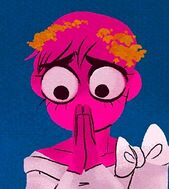

1. **STRATEGY 1**: Adding an Emotion analyzer to clarify ambigous sentiment and get better insights.

In [39]:
from transformers import pipeline

In [40]:
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [41]:
emotion_analyzer(df['Comment'].iloc[10]), df['Comment'].iloc[10]

([{'label': 'disgust', 'score': 0.8955783843994141}],
 'That moment when you kiss your sister in front of your brothers')

In [42]:
for i in range(len(df)):
  try:
    df.loc[i,"Emotions"]=emotion_analyzer(df['Comment'].iloc[i])[0]['label']
  except Exception as e:
    print(f"An error occur with the process of comment no.{i} (The original comment maybe only contains emojis and or punctuation !): \n {df['Comment'].iloc[i]}")
    df.loc[i,"Emotions"]=np.nan

Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors


An error occur with the process of comment no.4387 (The original comment maybe only contains emojis and or punctuation !): 
 siznnn .b, as mnnm 〜(꒪꒳꒪)〜ヽ(*ﾟｰヽ(*ﾟｰﾟ*)ﾉヽ(*ﾟｰﾟ*)ﾉ(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~(~‾▿‾)~〜(꒪꒳꒪)〜〜(꒪꒳꒪)〜┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツ)┬──┬ ¯\_(ツﾟ*)〜(꒪꒳꒪)〜〜(꒪꒳꒪)〜〜(꒪꒳꒪)〜＼(ﾟｰ〜(꒪꒳꒪)〜(~‾▿‾)~(~‾▿‾)~ﾟ＼)〜(꒪꒳꒪)〜〜(~‾▿‾)~〜(꒪꒳꒪)〜꒪)〜〜(꒪꒳꒪)〜(ノ^_^)ノ〜(꒪꒳꒪)〜ヘ(￣ω￣ヘ(~‾▿‾)~＼(ﾟｰﾟ＼)(ノ^_^)ノヾ(･ω･*)ﾉヾ(･ω･*)ﾉ (~‾▿‾)~〜(꒪꒳꒪☠️✨ヽ(*ﾟｰﾟ*)ﾉ


In [43]:
df.head()

,Date,Comment,Likes,Dislikes,Clean_comment,Sentiment score,Probability,Emotions
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...,5.0,0.855882,neutral
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677,The art style is mesmerizing Cant wait to see ...,5.0,0.487033,joy
2,"Mar 04, 2018",Im from discover too.EDIT: I cant believe I go...,30962,1265,Im from discover too EDIT I cant believe I got...,1.0,0.343923,surprise
3,"Mar 04, 2018",HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MO...,1830,24,HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MO...,5.0,0.727946,anger
4,"Mar 04, 2018",Hades phone: Apple=Pomegranate lol,949,6,Hades phone Apple Pomegranate lol,5.0,0.294891,neutral


In [44]:
df["Emotions"].value_counts()

,count
Emotions,
neutral,2038
joy,1926
surprise,1711
sadness,396
anger,219
disgust,188
fear,77


In [45]:
df["Emotions"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6556 entries, 0 to 6555
Series name: Emotions
Non-Null Count  Dtype 
--------------  ----- 
6555 non-null   object
dtypes: object(1)
memory usage: 51.3+ KB


**(a) Emotions Analysis:**

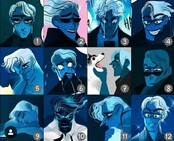

In [46]:
fig = px.histogram(
    df,
    x="Emotions",
    color="Sentiment score",
    labels={"Emotions": "Emotions", "Sentiment score": "Sentiment scores"},
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    height=500,
    width=800,
    xaxis_title="Emotions",
    legend_title="Sentiment scores",
    title_font_size=16,
    legend_font_size=12
)
fig.show()

In [187]:
df[(df['Sentiment score'] == 5) | (df['Sentiment score'] == 4) ]["Emotions"].value_counts().head(4)

,count
Emotions,
joy,1693
neutral,1011
surprise,934
sadness,106


* **Top 3 emotions (5 + 4 ⭐  score):** Joy > (Neutral) > Surprise > Sadness:

 --> Indeed readers were happy to finally see this webtoon on the application

 --> Readers were surprised to see Lore Olympus becoming on official "Originals" after reading it on Webtoon Discover or Tumblr.

In [186]:
df[(df['Sentiment score'] == 1) | (df['Sentiment score'] == 2) ]["Emotions"].value_counts().head(4)

,count
Emotions,
neutral,653
surprise,562
sadness,213
joy,113


In [188]:
df[(df['Sentiment score'] == 1) & (df["Emotions"] =="surprise") | (df['Sentiment score'] == 2) & (df["Emotions"] =="surprise")][90:].head()

,Date,Comment,Likes,Dislikes,Clean_comment,Sentiment score,Probability,Emotions,SS2,P2
5845,2018-03-08,YAAAASSSSS!!!!! SOSOSOSOSOSOOOOOO GLAD ITS BAA...,0,0,YAAAASSSSS SOSOSOSOSOSOOOOOO GLAD ITS BAAAACK,1.0,0.366937,surprise,1.0,0.364864
5840,2018-03-08,whys it not bloomin loading for,0,0,whys it not bloomin loading for,1.0,0.396085,surprise,1.0,0.396085
2509,2018-03-09,I am from discover...cant believe this webtoon...,2,0,I am from discover cant believe this webtoon g...,1.0,0.311274,surprise,1.0,0.292923
5834,2018-03-09,Was this reposted? I think Ive read this befor...,0,0,Was this reposted I think Ive read this before...,1.0,0.292774,surprise,5.0,0.500365
5821,2018-03-11,no... Now you look like youre abiut to get mar...,0,0,no Now you look like youre abiut to get married,1.0,0.540358,surprise,1.0,0.580024


* **Top 3 emotions (1 + 2 ⭐ score):** (Neutral) > Surprise > Sadness > Joy:

 --> After looking into comments classified as 1 or 2 with one of this emotions, we can make the hypothesis that most of them could have been classified as "3 stars - Neutral" and not negative/very negative. This indicate that we may improve the model accuracy or try another model with better performances.

In [185]:
df[df['Sentiment score'] == 3]["Emotions"].value_counts().head(4)

,count
Emotions,
neutral,374
surprise,215
joy,120
sadness,77


* **Top 3 emotions (3 ⭐ score ):** (Neutral) > Surprise > Joy > Sadness:

 --> Readers are surprised in many neutral comments.


**Globally, we can see that readers are positively surprised.**

**(b) Wordcloud Analysis: In-depth insights:**

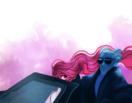

In [51]:
from wordcloud import WordCloud
from PIL import Image

def get_wordcloud(column):
  text = ' '.join(column.dropna())
  wordcloud = WordCloud(width=350, height=250, background_color='white', colormap='viridis').generate(text)
  return wordcloud

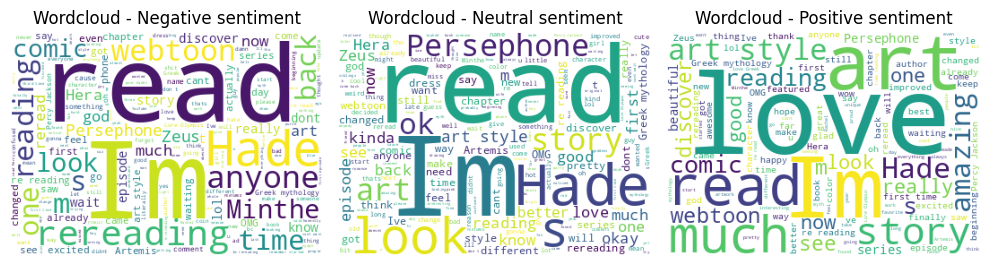

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Wordcloud for Sentiment scores 1 + 2
sub_df2 = df[(df['Sentiment score'] == 1) | (df['Sentiment score'] == 2)]
wordcloud2 = get_wordcloud(sub_df2["Comment"])
axes[0].imshow(wordcloud2)
axes[0].axis('off')
axes[0].set_title("Wordcloud - Negative sentiment")

# Wordcloud for Sentiment score 3
sub_df4 = df[df['Sentiment score'] == 3]
wordcloud4 = get_wordcloud(sub_df4["Comment"])
axes[1].imshow(wordcloud4)
axes[1].axis('off')
axes[1].set_title("Wordcloud - Neutral sentiment")

# Wordcloud for Sentiment scores 4 + 5
sub_df3 = df[(df['Sentiment score'] == 5) | (df['Sentiment score'] == 4)]
wordcloud3 = get_wordcloud(sub_df3["Comment"])
axes[2].imshow(wordcloud3)
axes[2].axis('off')
axes[2].set_title("Wordcloud - Positive sentiment")

plt.tight_layout()
plt.show()

* **Wordcloud ⭐+⭐⭐:** Interesting points turns around words like Read, Hades, Minthe, Comic, Discover.

This fits with the scenes that take place in the chapter, as we can see Hades and Minthe interacting together in a toxic way that can induce these negative comments from readers. Regarding words like read/reread/read/reread, comic, and discover, most readers express that they are coming from Webtoon Discover, which was created by the platform to develop the webtoon market as a self-publishing platform for artists to self-publish their comics.

* **Wordcloud ⭐⭐⭐⭐+⭐⭐⭐⭐⭐:** Interesting points turns around words like Love, Read, Art Style, Story, Amazing.



* **Wordcloud ⭐⭐⭐:** Interesting points turns around words like Hades, Read, Look, Story, Art Style.

Most of the Neutral comments turn around these words, moreover we notice comments that talk about the story, the art style and Hades, with this insights we can't say if it is with positive or negative emotion. To do so we can have a look on another wordcloud containing those words:

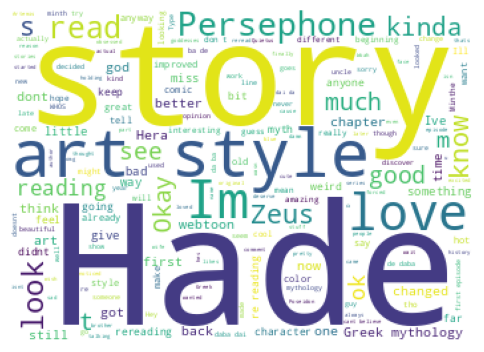

In [53]:
mask = sub_df4["Comment"].str.contains("story|art style|hades", case=False, na=False)
sb = sub_df4[mask].reset_index(drop=True)
wordcloud = get_wordcloud(sb["Comment"])
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

This wordcloud provides a deeper understanding of the neutral comments and reveals a strong focus on the 'art style' and 'story,' with diverse positive remarks reflected in words like 'love, 'beautiful,' and 'improved,' alongside more critical terms such as 'bad', 'look' and 'different'. Words like 'Hades' and 'Persephone' emphasize the characters’ **central role in the narrative**, while terms such as 'changed,' 'first,' and 'interesting' suggest a **mix of personal impressions and evolving perspectives**. This visualization captures the range of emotions and opinions, offering a well-rounded view of reader engagement.


**(c) Trend Analysis:**

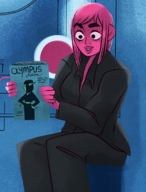



In [180]:
df["Date"] = pd.to_datetime(df["Date"], format="%b %d, %Y")
df = df.sort_values(by="Date")

# Grouping sentiment scores / month to smooth the trend
df_sentiment = df.resample("ME", on="Date")["Sentiment score"].mean().round(1).reset_index()


df_emotions = df.groupby([pd.Grouper(key="Date", freq="QE"), "Emotions"]).size().reset_index(name="Count")

# Sentiment Score evolution
fig1 = px.line(df_sentiment, x="Date", y="Sentiment score",
               markers=True,
               title="Sentiment score mean evolution through time",
               labels={"Sentiment score": "Sentiment score Mean", "Date": "Time"},
               line_shape="spline")

fig1.add_hline(
    y=3,
    annotation_text="Threshold = 3.0",
    line=dict(color="red",width=1)
    )

fig1.update_traces(line=dict(color="royalblue", width=3))
fig1.update_layout(
    xaxis=dict(title="Date", tickangle=-45),
    height=300,
    width=1000)


fig1.show()

On average, from 2018 to 2025 the scores are rather positive. We notice a fairly homogeneous and positive start but decreasing from 2018 to mid-2020 then slightly more dispersed scores from the end of 2022 which shows that readers react more strongly to the chapter, this corresponds to the period from which Lore Olympus gained its worldwide notoriety. This event can potentially explain the dispersion of opinions in comments.

In [179]:
# Comment Emotions distribution
fig2 = px.line(df_emotions, x="Date", y="Count", color="Emotions",
               markers=True,
               title="Comments emotions evolution through time",
               labels={"Count": "Occurrences", "Date": "Time"},
               line_shape="spline")

fig2.update_layout(
    xaxis=dict(title="Date", tickangle=-45),
    height=350,
    width=1000)
fig2.show()

From 2018 to 2023, positive emotions such as joy, surprise and neutrality are strongly dominant, then they are still dominant but significantly less strong.

In [101]:
# Group comments by Year to know how many comments we got through years
df.groupby(pd.Grouper(key="Date", freq="YE"))["Comment"].count()

,Comment
Date,
2018-12-31,2043
2019-12-31,1187
2020-12-31,1407
2021-12-31,778
2022-12-31,610
2023-12-31,245
2024-12-31,281
2025-12-31,5


2. **STRATEGY 2**: Applying BERT model on unpreprocessed textual data, directly on the comments of .the column "*Comment*" As seen previously in the model architecture, there is an embedding layer at the beginning of the neuronal network. We can try to apply

In [54]:
# TRY DIRECTLY ON COMMENT TO COMPARE IF THERE'S IMPROVEMENT
df[["SS2","P2"]]=df["Comment"].apply(lambda x: pd.Series(sentiment_score(x)))
df.head(3)

,Date,Comment,Likes,Dislikes,Clean_comment,Sentiment score,Probability,Emotions,SS2,P2
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57547,905,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...,5.0,0.855882,neutral,5.0,0.862345
1,"Mar 04, 2018",The art style is mesmerizing! Cant wait to see...,54364,677,The art style is mesmerizing Cant wait to see ...,5.0,0.487033,joy,5.0,0.688588
2,"Mar 04, 2018",Im from discover too.EDIT: I cant believe I go...,30962,1265,Im from discover too EDIT I cant believe I got...,1.0,0.343923,surprise,5.0,0.380996


In [193]:
# Display comments where p2<0.5 and p1 >0.5. The model is less confident about these predictions with the 2nd method.
df.loc[(df["P2"] < 0.5) & (df["Probability"] >= 0.5)]

,Date,Comment,Likes,Dislikes,Clean_comment,Sentiment score,Probability,Emotions,SS2,P2
2531,2018-03-04,its here! (inhuman squeals),2,0,its here inhuman squeals,1.0,0.684120,surprise,1.0,0.487417
4057,2018-03-04,lol i didnt even read the comic i just went to...,1,0,lol i didnt even read the comic i just went to...,1.0,0.518153,surprise,1.0,0.487955
4074,2018-03-04,"hades is as sexy as ever , persphone is as ado...",1,0,hades is as sexy as ever persphone is as adora...,5.0,0.624878,sadness,5.0,0.256687
6137,2018-03-04,"is this the same as the old one? Not new, just...",0,0,is this the same as the old one Not new just r...,1.0,0.520581,neutral,1.0,0.446252
3970,2018-03-04,This version has changed so much from the orig...,1,0,This version has changed so much from the orig...,5.0,0.538029,joy,5.0,0.478963
...,...,...,...,...,...,...,...,...,...,...
66,2024-06-02,anyone else here after the finale cause they a...,1,14,anyone else here after the finale cause they a...,1.0,0.548783,neutral,1.0,0.498733
2592,2024-06-13,the art style is wow😶‍😶😶🫥,2,1,the art style is wow‍,5.0,0.658075,surprise,4.0,0.372508
63,2024-06-14,Anyone else reading this again after finishing...,1,13,Anyone else reading this again after finishing...,5.0,0.503499,neutral,5.0,0.348985
4113,2024-11-26,I love how Minthes greed is the opening point ...,0,0,I love how Minthes greed is the opening point ...,5.0,0.515528,disgust,5.0,0.476174
